In [16]:
from rec.models.mnist_vae import MNISTVAE, MNISTVampVAE
from rec.core.utils import setup_logger

from rec.core.modules.snis_distribution import SNISDistribution

import os

import tensorflow as tf
tfl = tf.keras.layers

import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

data_save_dir = "../experimental_data/mnist_emp_bayes/"

In [2]:
# Taken from https://github.com/tensorflow/tensorflow/issues/31135#issuecomment-516526113
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
!ls ../../../../models/relative-entropy-coding/empirical-bayes-experiments/mnist

gaussian  gaussian_with_constraint  mog  snis  vamp


In [4]:
gaussian_save_dir = "../../../../models/relative-entropy-coding/empirical-bayes-experiments/mnist/gaussian"
max_gaussian_save_dir = "../../../../models/relative-entropy-coding/empirical-bayes-experiments/mnist/gaussian_with_constraint"
mog_save_dir = "../../../../models/relative-entropy-coding/empirical-bayes-experiments/mnist/mog"
snis_save_dir = "../../../../models/relative-entropy-coding/empirical-bayes-experiments/mnist/snis"
vamp_save_dir = "../../../../models/relative-entropy-coding/empirical-bayes-experiments/mnist/vamp"

In [5]:
# Standard Gaussian VAE
gaussian_vae = MNISTVAE(name="gaussian_mnist_vae", 
                        prior=tfd.Normal(loc=tf.zeros(50), scale=tf.ones(50)))

# Standard Gaussian VAE with max-ELBO
max_gaussian_vae = MNISTVAE(name="max_gaussian_mnist_vae", prior=tfd.Normal(loc=tf.zeros(50), scale=tf.ones(50)))

# MoG VAE
# Create MoG
num_components = 100

loc = tf.Variable(tf.random.uniform(shape=(50, num_components), minval=-1., maxval=1.))
log_scale = tf.Variable(tf.random.uniform(shape=(50, num_components), minval=-1., maxval=1.))

scale = 1e-5 + tf.nn.softplus(log_scale)

components = tfd.Normal(loc=loc,
                        scale=scale)

mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=[1. / num_components] * num_components),
                                components_distribution=components)

# Instantiate model
mog_vae = MNISTVAE(name="mog_mnist_vae", 
                   prior=mixture)

# VampVAE
vamp_vae = MNISTVampVAE(name="vamp_mnist_vae", latents=50)

# SNIS VAE
snis_network = tf.keras.Sequential([
            tfl.Dense(units=100,
                      activation=tf.nn.tanh),
            tfl.Dense(units=100,
                      activation=tf.nn.tanh),
            tfl.Dense(units=1)
        ])

prior = SNISDistribution(energy_fn=snis_network,
                         prior=tfd.Normal(loc=tf.zeros(50),
                                          scale=tf.ones(50)),
                         K=1024)

snis_vae = MNISTVAE(name="snis_mnist_vae",
                     prior=prior)

Instructions for updating:
The `logits` property will return `None` when the distribution is parameterized with `logits=None`. Use `logits_parameter()` instead.


In [6]:
vaes = {
    "gaussian": (gaussian_vae, gaussian_save_dir),
    #"max_gaussian": (max_gaussian_vae, max_gaussian_save_dir),
#     #"mog": (mog_vae, mog_save_dir),
#    "vamp": (vamp_vae, vamp_save_dir),
#    "snis": (snis_vae, snis_save_dir)
}

In [7]:
for k, (model, save_dir) in vaes.items():

    ckpt = tf.train.Checkpoint(model=model)
    
    if not os.path.exists(save_dir):
        print(f"{k} has not been trained yet!")
        continue

    manager = tf.train.CheckpointManager(ckpt, save_dir, max_to_keep=3)

    model(tf.zeros([1, 28, 28, 1]))
    ckpt.restore(manager.latest_checkpoint)

    if manager.latest_checkpoint:
        print(f"Restored {manager.latest_checkpoint}")

Restored ../../../../models/relative-entropy-coding/empirical-bayes-experiments/mnist/gaussian/ckpt-287


In [ ]:


gaussian_ckpt = tf.train.Checkpoint(model=gaussian_vae)

gaussian_manager = tf.train.CheckpointManager(gaussian_ckpt, gaussian_save_dir, max_to_keep=3)

gaussian_vae(tf.zeros([1, 28, 28, 1]))
gaussian_ckpt.restore(gaussian_manager.latest_checkpoint)

if gaussian_manager.latest_checkpoint:
    print(f"Restored {gaussian_manager.latest_checkpoint}")

In [6]:


mog_ckpt = tf.train.Checkpoint(model=mog_vae)

mog_manager = tf.train.CheckpointManager(mog_ckpt, mog_save_dir, max_to_keep=3)

mog_vae(tf.zeros([1, 28, 28, 1]))
mog_ckpt.restore(mog_manager.latest_checkpoint)

if mog_manager.latest_checkpoint:
    print(f"Restored {mog_manager.latest_checkpoint}")

Instructions for updating:
The `logits` property will return `None` when the distribution is parameterized with `logits=None`. Use `logits_parameter()` instead.
Restored ../../../../models/relative-entropy-coding/empirical-bayes-experiments/mnist/mog/ckpt-243


In [5]:


vamp_ckpt = tf.train.Checkpoint(model=vamp_vae)

vamp_manager = tf.train.CheckpointManager(vamp_ckpt, vamp_save_dir, max_to_keep=3)

vamp_vae(tf.zeros([1, 28, 28, 1]))
vamp_ckpt.restore(vamp_manager.latest_checkpoint)

if vamp_manager.latest_checkpoint:
    print(f"Restored {vamp_manager.latest_checkpoint}")

Restored ../../../../models/relative-entropy-coding/empirical-bayes-experiments/mnist/vamp/ckpt-5090


In [8]:


snis_ckpt = tf.train.Checkpoint(model=snis_vae)

snis_manager = tf.train.CheckpointManager(snis_ckpt, snis_save_dir, max_to_keep=3)

snis_vae(tf.zeros([1, 28, 28, 1]))
snis_ckpt.restore(snis_manager.latest_checkpoint)

if snis_manager.latest_checkpoint:
    print(f"Restored {snis_manager.latest_checkpoint}")

Restored ../../../../models/relative-entropy-coding/empirical-bayes-experiments/mnist/snis/ckpt-677


In [8]:
dataset = tfds.load("binarized_mnist",
                    data_dir="/scratch/gf332/datasets/binarized_mnist")

test_ds = dataset["test"]

test_ds = test_ds.map(lambda x: tf.cast(x["image"], tf.float32))

IWAE lower bound:

$$
\log p(x) \geq \mathbb{E}_{z_1,...,z_k \sim q(z \mid x)}\left[ \log\left(\frac1k \sum_{i=1}^k \frac{p(x, z_i)}{q(z_i\mid x)}\right)\right]
$$
The right side is equal to
$$
\mathbb{E}_{z_1,...,z_k \sim q(z \mid x)}\left[ -\log k + \log \sum_{i=1}^k\exp\left\{\log p(x \mid z_i) + \log p(z_i) - \log q(z_i \mid x)\right\} \right]
$$

In [19]:
K = 1000
num_samples = 1

log_liks = []

model = vaes["gaussian"][0]

for i in tqdm(test_ds.take(num_samples), total=num_samples):

    reconstruction = model(i[None, ...], training=True)[0,...,0]

    samples = tf.reshape(model.posterior.sample(K), [K, -1])

    post_prob = model.posterior.log_prob(samples)
    post_prob = tf.reduce_sum(post_prob, axis=1)
    
    np.save(f"{data_save_dir}/latent_50_gauss_post_loc.npy", model.posterior.loc.numpy())
    np.save(f"{data_save_dir}/latent_50_gauss_post_scale.npy", model.posterior.scale.numpy())
    
    np.save(f"{data_save_dir}/latent_50_gauss_prior_loc.npy", model.prior.loc.numpy())
    np.save(f"{data_save_dir}/latent_50_gauss_prior_scale.npy", model.prior.scale.numpy())

    prior_prob = model.prior.log_prob(samples)
    prior_prob = tf.reduce_sum(prior_prob, axis=1)

    likelihood_loc = model.decoder(samples)
    likelihood_dist = tfd.Bernoulli(probs=tf.clip_by_value(likelihood_loc, 1e-20, 1 - 1e-20))

    likelihood = likelihood_dist.log_prob(i)
    likelihood = tf.einsum("ijkl -> i", likelihood)

    log_weights = prior_prob + likelihood - post_prob 

    log_lik = tf.reduce_logsumexp(log_weights)
    log_lik = log_lik - tf.math.log(tf.cast(K, tf.float32))

    log_liks.append(log_lik)

In [17]:
np.save

<function numpy.save(file, arr, allow_pickle=True, fix_imports=True)>

In [10]:
mean, var = tf.nn.moments(tf.convert_to_tensor(log_liks), axes=[0])

print(f"Mean: {mean:.4f}")
print(f"Standard deviation: {tf.sqrt(var):.4f}")

Mean: -88.9366
Standard deviation: 22.2782


In [11]:
kls = []
num_samples = 100

for i in tqdm(test_ds.take(num_samples), total=num_samples):
    
    reconstruction = model(i[None, ...], training=True)[0,...,0]
    
    samples = model.posterior.sample()

    post_prob = model.posterior.log_prob(samples)
    prior_prob = model.prior.log_prob(samples)
    
    kl = tf.reduce_sum(post_prob - prior_prob)
    
    kls.append(kl)

In [16]:
for i in test_ds.take(1):

    reconstruction = gaussian_vae(i[None, ...], training=True)[0,...,0]

    sample = gaussian_vae.posterior.sample()
    
    kls = gaussian_vae.posterior.log_prob(sample) - gaussian_vae.prior.log_prob(sample)

<BarContainer object of 50 artists>

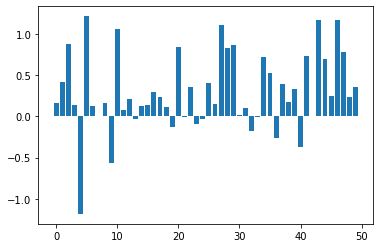

In [17]:
plt.bar(tf.range(50, dtype=tf.float32), kls[0])

In [14]:
tf.reduce_max(kls)

<tf.Tensor: id=1095, shape=(), dtype=float32, numpy=3.2038617>

In [29]:
tf.reduce_logsumexp(kls * 100) / 100

<tf.Tensor: id=1325, shape=(), dtype=float32, numpy=3.20568>